<a href="https://colab.research.google.com/github/keithth/AI_Apps/blob/main/Build_a_Custom_AI_Agent_with_Haystack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Custom AI Agent with Haystack

*Notebook by [Bilge Yucel](https://www.linkedin.com/in/bilge-yucel/) for Code & Deploy. Watch the recording [here](https://www.linkedin.com/events/code-deploy-buildyourfirstgenai7226658275792932864/comments/)*

📚 Useful Resources
* [🌐 Website](https://haystack.deepset.ai/)
* [📘 Documentation](https://docs.haystack.deepset.ai/docs)
* [🧑‍🏫 Tutorials](https://haystack.deepset.ai/tutorials)
* [🧑‍🍳 Cookbooks](https://github.com/deepset-ai/haystack-cookbook)

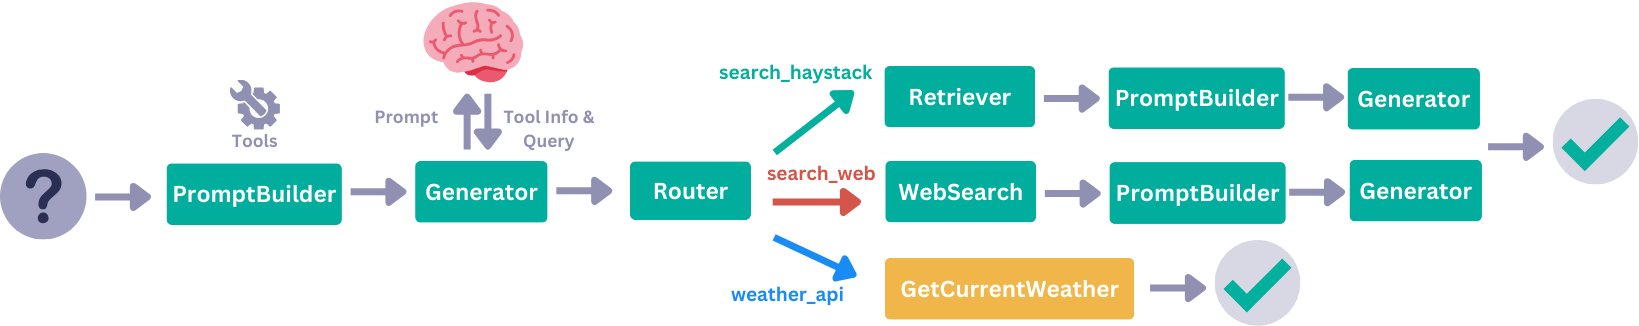

>[Build an AI Agent with Haystack](#scrollTo=oXOLE-gZ5Bz9)

>>[Tools ⚒️](#scrollTo=sj6RkPEd9Qyr)

>>>[Indexing for RAG](#scrollTo=CLcmK85e96hL)

>>[RAG](#scrollTo=mnOh6_0A-USp)

>>[Web Search](#scrollTo=Jcql4NR8AveC)

>>[Weather API](#scrollTo=uNS-oa_0CX-i)

>>[Router](#scrollTo=nXpKuSz8B10i)

>>[Agent 🤖](#scrollTo=YWP5qKNbExoj)

>>[Live Demo](#scrollTo=C3Q5Ji1QRyeP)



In [ ]:
!pip install haystack-ai trafilatura

Get keys from [serper.dev](https://serper.dev/) and [Hugging Face](https://huggingface.co/)

In [ ]:
from getpass import getpass
import os

os.environ["SERPERDEV_API_KEY"] = getpass('SERPERDEV_API_KEY')
os.environ["HF_API_TOKEN"] = getpass('HF_API_TOKEN')

SERPERDEV_API_KEY··········
HF_API_TOKEN··········


In [ ]:
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceAPIGenerator

# Prompt for the Agent

agent_prompt_template = """<s>[INST]
You are a virtual assistant, equipped with the following tools:

"tools": [
  {
    "name": "search_web",
    "description": "Access to Google search, use this tool whenever information on recents events is needed",
    "parameters": {
      "type": "object",
      "properties": {
        "query": {
          "type": "string",
          "description": "query to search in web"
        }
      }
    }
  },
  {
    "name": "search_haystack",
    "description": "Access to Haystack documentation, use this tool whenever information on building with LLMs, custom AI applications, Haystack, the open source LLM framework, is needed",
    "parameters": {
      "type": "object",
      "properties": {
        "query": {
          "type": "string",
          "description": "query to search in the database"
        }
      }
    }
  },
  {
    "name": "weather_api",
    "description": "Access to a weather api, that can get the current day's weather forecast
    "parameters": {
      "type": "object",
      "properties": {
        "query": {
          "type": "string",
          "description": "The city name, e.g. Paris, New York"
        }
      }
    }
  },
]

Select the most appropriate tool to resolve the user's query. Respond in JSON format, specifying the user request, modified query and the chosen tool for the response.
If you can't match user query to an above listed tools, respond with `search_web`.

Here are some examples:

{
  "user_request": "Why did Elon Musk recently sue OpenAI?",
  "tool_name": "search_web",
  "query": "Why did Elon Musk recently sue OpenAI?"
}
{
  "user_request": "What are the init parameters of HuggingFaceAPIGenerator component?"
  "tool_name": "search_haystack"
  "query": "What are the init parameters of HuggingFaceAPIGenerator component?"
}
{
  "user_request": "What are the weather like in Istanbul?"
  "tool_name": "weather_api"
  "query": "Istanbul"
}

Choose the best tool (or none) for each user request and modify the query, considering the current context of the conversation specified above.

Here's the user_request: {{query}} [/INST]
"""

prompt_builder_for_agent = PromptBuilder(template=agent_prompt_template)
llm_for_agent = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "mistralai/Mistral-7B-Instruct-v0.3"})



## Tools ⚒️

* RAG Pipeline (Indexing + Query)
* Web Search
* Weather API (Custom component)

### Indexing for RAG

In [ ]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter

document_store = InMemoryDocumentStore()

# Indexing pipeline

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(instance=LinkContentFetcher(), name="fetcher")
indexing_pipeline.add_component(instance=HTMLToDocument(), name="converter")
indexing_pipeline.add_component(instance=DocumentCleaner(), name="cleaner")
indexing_pipeline.add_component(instance=DocumentSplitter(split_by="word", split_length=512, split_overlap=50), name="splitter")
indexing_pipeline.add_component(instance=DocumentWriter(document_store = document_store), name="writer")

indexing_pipeline.connect("fetcher.streams", "converter.sources")
indexing_pipeline.connect("converter.documents", "cleaner")
indexing_pipeline.connect("cleaner", "splitter")
indexing_pipeline.connect("splitter", "writer.documents")

# index some documentation pages to use for RAG
indexing_pipeline.run({
    "fetcher": {
        "urls": [
            "https://docs.haystack.deepset.ai/docs/huggingfacelocalgenerator",
            "https://docs.haystack.deepset.ai/docs/huggingfacelocalchatgenerator",
            "https://docs.haystack.deepset.ai/reference/generators-api",
            "https://haystack.deepset.ai/overview/quick-start",
            "https://haystack.deepset.ai/overview/intro"
            ]}})

{'writer': {'documents_written': 14}}

## RAG

In [ ]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

# RAG pipeline
retriever = InMemoryBM25Retriever(document_store=document_store)
rag_prompt_template = """<s>[INST]
Answer the following query given the documents retrieved from Haystack's documentation.

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}} [/INST]
"""
prompt_builder_for_rag = PromptBuilder(template=rag_prompt_template, required_variables=["documents", "query"])
llm_for_rag = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "mistralai/Mistral-Nemo-Instruct-2407"})

## Web Search

In [ ]:
from haystack.components.websearch.serper_dev import SerperDevWebSearch

# Web RAG pipeline

prompt_for_websearch = """ "<s>[INST]
Answer the following query given the documents retrieved from the web.
Your answer shoud indicate that your answer was generated from websearch.

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}} [/INST]
"""

websearch = SerperDevWebSearch()
prompt_builder_for_websearch = PromptBuilder(template=prompt_for_websearch, required_variables=["documents", "query"])
llm_for_web = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "mistralai/Mistral-7B-Instruct-v0.3"})

## Weather API

Get your API key from [weatherapi.com](https://www.weatherapi.com/my/)

In [ ]:
weather_api_key = getpass("WEATHER_API")

WEATHER_API··········


In [ ]:
import requests
from haystack import component

# GetCurrentWeather
@component
class GetCurrentWeather:
  def __init__(self, api_key):
    self.api_key = api_key

  @component.output_types(text=str)
  def run(self, city:str):
    response = requests.get(f'https://api.weatherapi.com/v1/current.json?q={city}&key={self.api_key}').json()

    current_condition = response["current"]["condition"]["text"]
    current_temp = response["current"]["temp_c"]
    text = f'The weather in {city} is {current_condition} with {current_temp} degrees'

    return {"text": text}

## Router

In [ ]:
from haystack.components.routers import ConditionalRouter

# Router
main_routes = [
        {
        "condition": "{{'weather_api' in tool_name}}",
        "output": "{{query}}",
        "output_name": "weather_api",
        "output_type": str,
    },
    {
        "condition": "{{'search_haystack' in tool_name}}",
        "output": "{{query}}",
        "output_name": "search_haystack",
        "output_type": str,
    },
    {
        "condition": "{{'search_web' in tool_name}}",
        "output": "{{query}}",
        "output_name": "search_web",
        "output_type": str,
    },
]

tool_router = ConditionalRouter(main_routes)

### Connection Components

In [ ]:
from haystack import component
from typing import List
import json

## AnswerParser
@component
class AnswerParser:

  @component.output_types(tool_name=str, query=str)
  def run(self, replies:List[str]):
    reply = json.loads(replies[0])

    tool_name = reply["tool_name"]
    query = reply["query"]

    return {"tool_name": tool_name, "query":query}

## Agent 🤖


In [ ]:
from haystack import Pipeline

agent = Pipeline()
agent.add_component("prompt_builder_for_agent", prompt_builder_for_agent)
agent.add_component("llm_for_agent", llm_for_agent)
agent.add_component("answer_parser", AnswerParser())
agent.add_component("tool_router", tool_router)

# web
agent.add_component("websearch", websearch)
agent.add_component("prompt_builder_for_websearch", prompt_builder_for_websearch)
agent.add_component("llm_for_web", llm_for_web)

# RAG
agent.add_component("retriever", retriever)
agent.add_component("prompt_builder_for_rag", prompt_builder_for_rag)
agent.add_component("llm_for_rag", llm_for_rag)

# Weather API
agent.add_component("get_weather", GetCurrentWeather(weather_api_key))

In [ ]:
agent.connect("prompt_builder_for_agent", "llm_for_agent")
agent.connect("llm_for_agent","answer_parser")
agent.connect("answer_parser.query", "tool_router.query")
agent.connect("answer_parser.tool_name", "tool_router.tool_name")

# Web Search
agent.connect("tool_router.search_web", "websearch.query")
agent.connect("tool_router.search_web", "prompt_builder_for_websearch.query")
agent.connect("websearch.documents", "prompt_builder_for_websearch.documents")
agent.connect("prompt_builder_for_websearch", "llm_for_web")

# RAG
agent.connect("tool_router.search_haystack", "retriever.query")
agent.connect("tool_router.search_haystack", "prompt_builder_for_rag.query")
agent.connect("retriever.documents", "prompt_builder_for_rag.documents")
agent.connect("prompt_builder_for_rag", "llm_for_rag")

# Weather API
agent.connect("tool_router.weather_api", "get_weather")

🚅 Components
  - prompt_builder_for_agent: PromptBuilder
  - llm_for_agent: HuggingFaceAPIGenerator
  - answer_parser: AnswerParser
  - tool_router: ConditionalRouter
  - websearch: SerperDevWebSearch
  - prompt_builder_for_websearch: PromptBuilder
  - llm_for_web: HuggingFaceAPIGenerator
  - retriever: InMemoryBM25Retriever
  - prompt_builder_for_rag: PromptBuilder
  - llm_for_rag: HuggingFaceAPIGenerator
  - get_weather: GetCurrentWeather
🛤️ Connections
  - prompt_builder_for_agent.prompt -> llm_for_agent.prompt (str)
  - llm_for_agent.replies -> answer_parser.replies (List[str])
  - answer_parser.query -> tool_router.query (str)
  - answer_parser.tool_name -> tool_router.tool_name (str)
  - tool_router.search_web -> websearch.query (str)
  - tool_router.search_web -> prompt_builder_for_websearch.query (str)
  - tool_router.search_haystack -> retriever.query (str)
  - tool_router.search_haystack -> prompt_builder_for_rag.query (str)
  - tool_router.weather_api -> get_weather.city (st

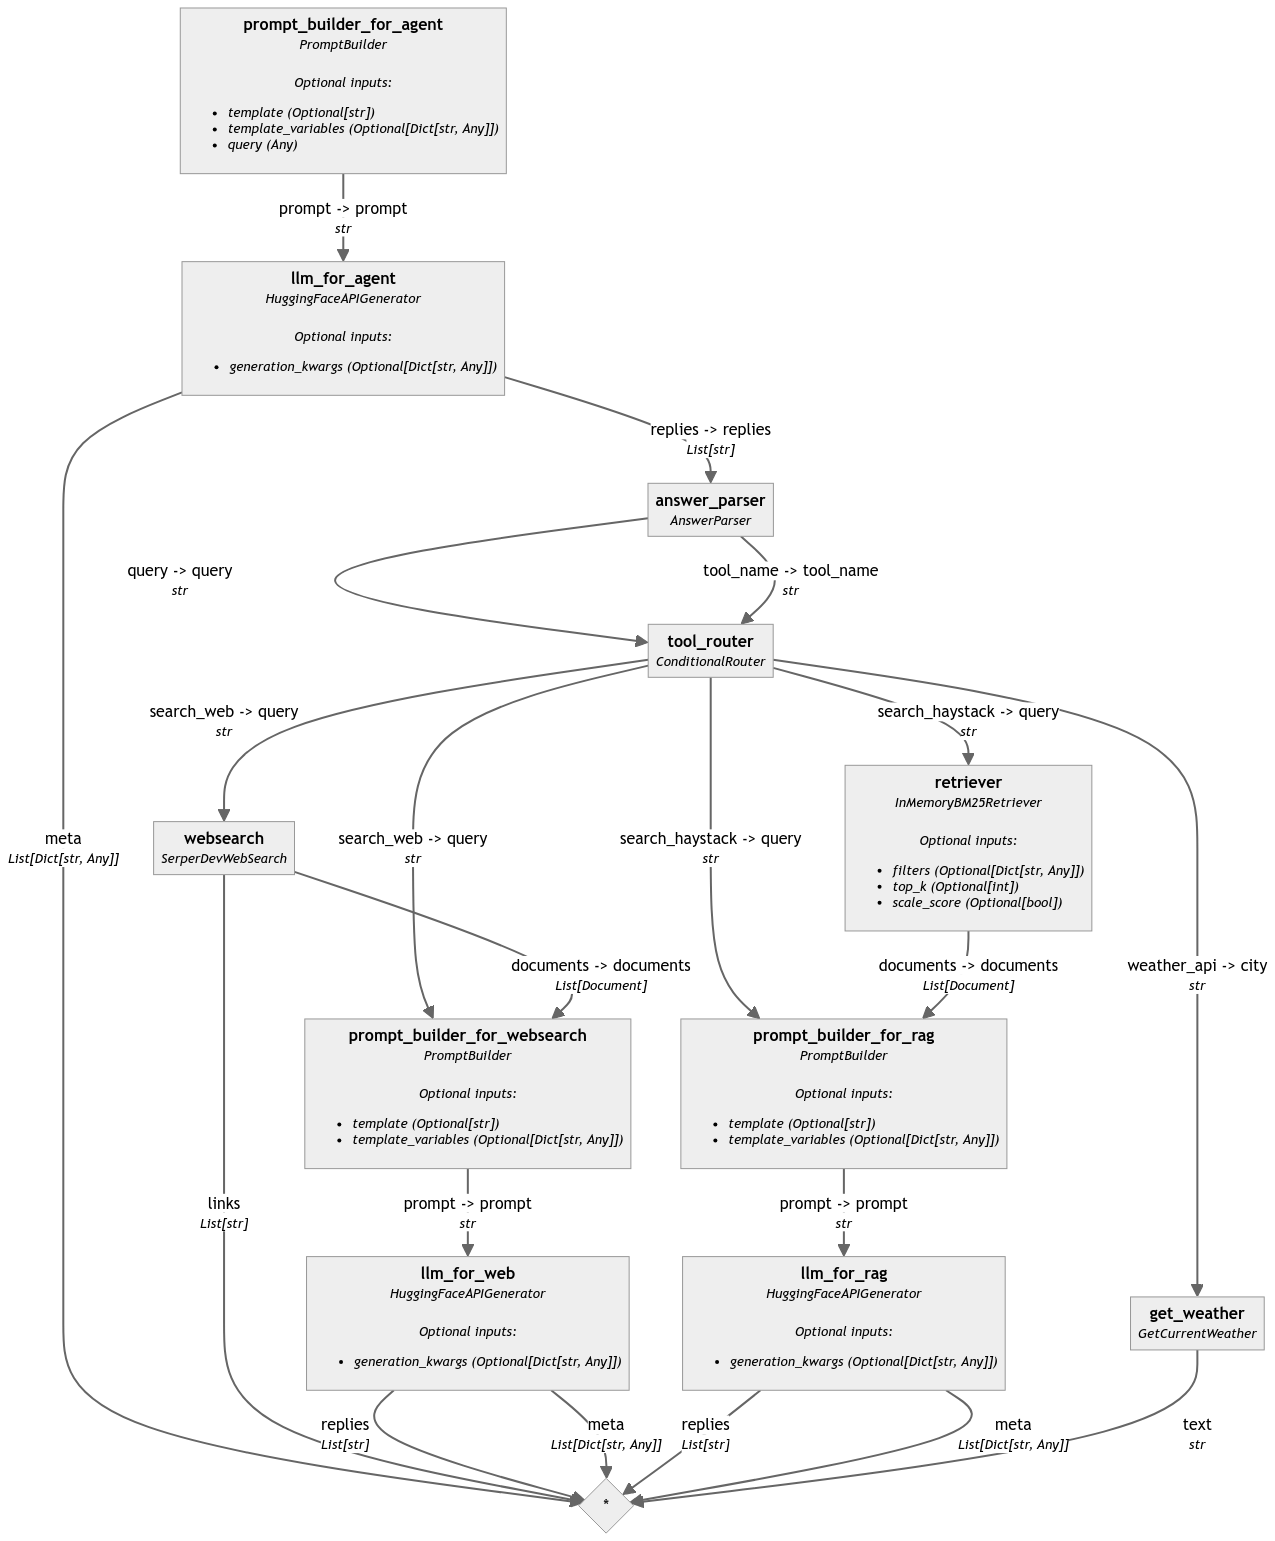

In [ ]:
agent.show()

In [ ]:
query = "Can you tell me why cats purr?"
agent.run({"prompt_builder_for_agent": {"query": query}}, include_outputs_from={"llm_for_agent"})

{'llm_for_agent': {'meta': [{'model': 'mistralai/Mistral-7B-Instruct-v0.3',
    'finish_reason': 'eos_token',
    'usage': {'completion_tokens': 46}}],
  'replies': ['{\n  "user_request": "Can you tell me why cats purr?",\n  "tool_name": "search_web",\n  "query": "Why do cats purr?"\n}']},
 'websearch': {'links': ['https://www.newscientist.com/question/why-do-cats-purr/',
   'https://www.webmd.com/pets/cats/why-do-cats-purr',
   'https://www.reddit.com/r/askscience/comments/myqmb/why_do_cats_purr/',
   'https://www.whiskas.co.uk/kit/why-do-cats-purr',
   'https://www.scientificamerican.com/article/why-do-cats-purr/',
   'https://www.forbes.com/advisor/pet-insurance/pet-care/why-do-cats-purr/',
   'https://www.cats.org.uk/cats-blog/why-does-my-cat-purr',
   'https://www.quora.com/When-do-cats-purr',
   'https://www.science.org/content/article/how-do-cats-purr-new-finding-challenges-long-held-assumptions']},
 'llm_for_web': {'replies': ["Cats purr for a variety of reasons, and it's not a

## Live Demo

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2


In [ ]:
import gradio as gr

def chatbot(message, history):
    response = agent.run({"prompt_builder_for_agent": {"query": message}}, include_outputs_from={"tool_router", "answer_parser"})
    answer = ""

    if "llm_for_web" in response.keys():
      answer = response["llm_for_web"]["replies"][0]
    elif "llm_for_rag" in response.keys():
      answer = response["llm_for_rag"]["replies"][0]
    else:
      answer = response["get_weather"]["text"]

    return answer


demo = gr.ChatInterface(
    fn=chatbot,
    examples=[
        "What's Einstein's first name?",
        "How is the weather in Toronto?",
        "Why do cats purr?",
        "What is Haystack?"
    ],
    title="Ask me about anything!",
)

In [ ]:
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5b6427ee2e64ca350a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
